https://github.com/Junst/TSP-Genetic-Algorithm/blob/master/TSP_GA.py

***유전 알고리즘***

THRESHOLD : 임계점

population_size : 모집단 크기

Generation_Count : 염색체 수

In [91]:
import random
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import time

In [92]:
MUTATION_RATE = 40
MUTATION_COUNT = 2
THRESHOLD = 35000
UNIFORMCROSSOVER_RATE = 0.5

In [93]:
def read_csv(csvf): #csv파일 읽기
    city = pd.read_csv(csvf, header=None)
    #City = np.genfromtxt(open(csvf,"rb"), dtype = float, delimiter=",", skip_header=0)
    print(type(city.to_numpy()))
    return city.to_numpy()

cityCoordinates = read_csv(csv_file)
citySize = len(read_csv(csv_file))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [94]:
class Genome():
    chromosomes = []
    fitness = 100000

    def __init__(self, numberOfchromosomes=None):
        if numberOfchromosomes is not None:
            self.chromosomes = list(range(numberOfchromosomes))
            randShuffle(self.chromosomes)

def randShuffle(listToShuffle):
    return random.shuffle(listToShuffle)

In [95]:
def init_population(size) :
    initial_population = []
    for i in range(size):
        newGenome = Genome()
        newGenome.chromosomes = random.sample(range(1, citySize), citySize - 1)
        newGenome.chromosomes.insert(0, 0)
        newGenome.chromosomes.append(0)
        newGenome.fitness = Evaluate(newGenome.chromosomes)
        initial_population.append(newGenome)
    return initial_population

def Evaluate(chromosomes):
    Fitness = 0
    for i in range(len(chromosomes) - 1):
        p1 = cityCoordinates[chromosomes[i]]
        p2 = cityCoordinates[chromosomes[i + 1]]
        Fitness += Euclidean_distance(p1, p2)
    Fitness = np.round(Fitness, 2)
    return Fitness

def Euclidean_distance(x, y):
    dist = np.linalg.norm(np.array(x)-np.array(y))
    return dist


def findBestGenome(population):
    allFitness = [i.fitness for i in population]
    bestFitness = min(allFitness)
    return population[allFitness.index(bestFitness)]


In [96]:
#선택연산
def TournamentSelection(population, k):
    select = [population[random.randrange(0, len(population))] for i in range(k)]
    bestGenome = findBestGenome(select)
    return bestGenome

def Reproduction(population): #...
    parent1 = TournamentSelection(population, 15).chromosomes
    parent2 = TournamentSelection(population, 15).chromosomes
    while parent1 == parent2:
        parent2 = TournamentSelection(population, 15).chromosomes

    return OrderCrossover(parent1, parent2)

def randRange(first,last):
    return random.randint(first,last)

#교차연산
def OrderCrossover(parent1, parent2):
    child = Genome(None)
    child.chromosomes = []
    firstIndex = randRange(0,len(parent1)-1)
    secondIndex = randRange(firstIndex, len(parent1)-1)
    innerSet = parent1[firstIndex:secondIndex]
    startSet = []
    endSet = []
    for _, value in enumerate([item for item in parent2 if item not in innerSet]):
        if len(startSet)<firstIndex:
            startSet.append(value)
        else:
            endSet.append(value)
    child.chromosomes = startSet + innerSet + endSet
    
    if random.randrange(0, 100) < MUTATION_RATE:
        child.chromosomes = InversionMutation(child.chromosomes)
    
    child.fitness = Evaluate(child.chromosomes)
    return child

#변이 연산
def InversionMutation(chromo) :
    for x in range(MUTATION_COUNT):
        p1, p2 = [random.randrange(1, len(chromo) - 1) for i in range(2)]
        while p1 == p2 or p1 > p2:
            p1 = random.randint(0, len(chromo) - 1)
            p2 = random.randint(0, len(chromo) - 1)
        log = chromo[p1:p2]
        log = log[::-1]
        chromo = chromo[:p1] + log +chromo[p2:]
    return chromo

In [97]:
#시각화
def fitness_plot(generation, allBestFitness):
    plt.plot(range(0, generation), allBestFitness, c='blue')
    plt.xlabel('Generations')
    plt.ylabel('Best Fitness')
    plt.title('Fitness Function')
    plt.show()
    
def city_visualize(bestGenome, city):
    start = None
    for x, y in city:
        if start is None: #시작지점이면 표시
            start = city[0]
            plt.scatter(start[0], start[1], c="green", marker=">")
            plt.annotate("Start", (x + 2, y - 2), color='red')
        else: #시작지점 아니면
            plt.scatter(x, y, marker='.', s=10, c="black")

    #edge 표현을 위한 x, y 범위
    x_edge = [city[i][0] for i in bestGenome.chromosomes]
    y_edge = [city[i][1] for i in bestGenome.chromosomes]

    plt.plot(x_edge, y_edge, color="blue", linewidth=0.07, linestyle="-")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('City Edges')
    plt.show()

def GeneticAlgorithm(populationSize, Generation_Count):
    allBestFitness = []
    population = init_population(populationSize)
    generation = 0
    TotalBestFitness = 100000
    TotalBestPath = []
    
    start = time.time()
    
    while generation < Generation_Count:
        generation += 1

        for i in range(populationSize):
            population.append(Reproduction(population))
        
        for genom in population:
            if genom.fitness > THRESHOLD:
                population.remove(genom)
        
        averageFitness = round(np.sum([genom.fitness for genom in population]) / len(population), 2)
        bestGenome = findBestGenome(population)
        if bestGenome.fitness < TotalBestFitness:
            TotalBestFitness = bestGenome.fitness
            TotalBestPath = bestGenome.chromosomes
        print("\n" * 5)
        print("Generation: {0}\nPopulation Size: {1}\t Average Fitness: {2}\nBest Fitness: {3}"
              .format(generation, len(population), averageFitness,
                      bestGenome.fitness))

        allBestFitness.append(bestGenome.fitness)
    
    print("\nTotal Best Fitness : ",TotalBestFitness)
    
    end = time.time()
    
    print("Total time : ", end-start) # 소요 시간 표기, Working Time
    
    #시각화
    fitness_plot(generation, allBestFitness)
    city_visualize(bestGenome, cityCoordinates)

    #csv 파일 경로 저장
    f = open('temp.csv', 'w', newline='')
    wr = csv.writer(f)
    for i in range(0, citySize):
        wr.writerow([TotalBestPath[i]])
    f.close()







Generation: 1
Population Size: 15	 Average Fitness: 43529.4
Best Fitness: 42737.12






Generation: 2
Population Size: 15	 Average Fitness: 43029.62
Best Fitness: 42611.71






Generation: 3
Population Size: 15	 Average Fitness: 42790.45
Best Fitness: 42579.31






Generation: 4
Population Size: 15	 Average Fitness: 42617.87
Best Fitness: 42373.12






Generation: 5
Population Size: 15	 Average Fitness: 42452.59
Best Fitness: 41890.17






Generation: 6
Population Size: 15	 Average Fitness: 42201.81
Best Fitness: 41845.38






Generation: 7
Population Size: 15	 Average Fitness: 41977.26
Best Fitness: 41714.9






Generation: 8
Population Size: 15	 Average Fitness: 41765.88
Best Fitness: 41520.96






Generation: 9
Population Size: 15	 Average Fitness: 41627.32
Best Fitness: 41490.76






Generation: 10
Population Size: 15	 Average Fitness: 41551.87
Best Fitness: 41474.45






Generation: 11
Population Size: 15	 Average Fitness: 41477.3
Best Fitness: 41175.02






Gener

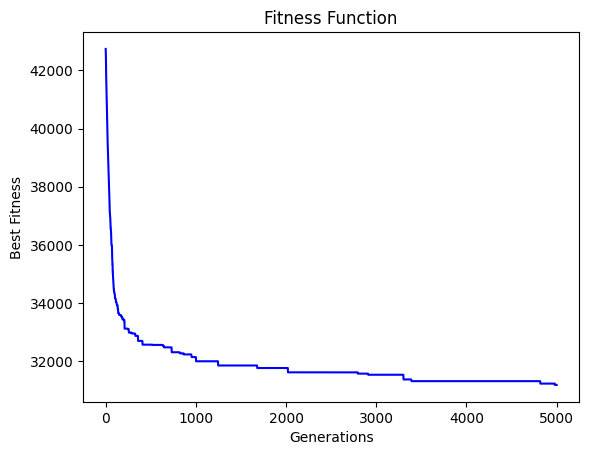

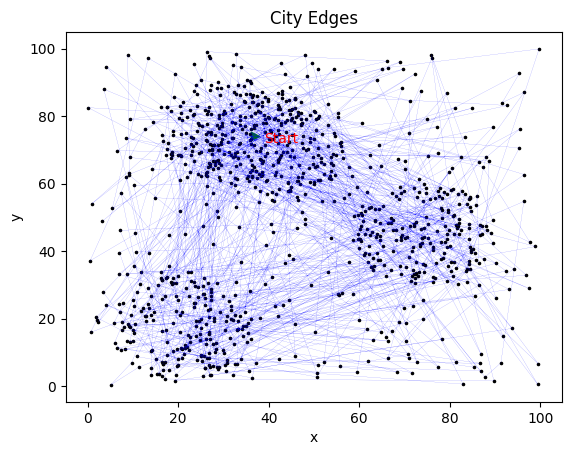

In [98]:
#Population size, Generation Count 입력
GeneticAlgorithm(populationSize=15, Generation_Count=5000)